**Appendix E – State Space Models**

_This notebook contains all the sample code in Appendix E._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/Appendix_E_state_space_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/Appendix_E_state_space_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

And PyTorch ≥ 2.4.0:

In [2]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.4.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [5]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# LTI SSM

In [6]:
import torch
import torch.nn as nn

In [7]:
class BasicSSM(nn.Module):
    def __init__(self, d_input, d_state, d_output):
        super().__init__()
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Parameter(torch.randn(d_state, d_input))
        self.C = nn.Parameter(torch.randn(d_output, d_state))
        self.D = nn.Parameter(torch.randn(d_output, d_input))

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = torch.zeros(batch_size, self.d_state, device=x.device)
        outputs = []
        for i in range(seq_len):
            x_t = x[:, i, :]
            h = h @ self.A.T + x_t @ self.B.T
            y = h @ self.C.T + x_t @ self.D.T
            outputs.append(y)

        return torch.stack(outputs, dim=1)

In [8]:
batch_size, seq_len, d_input = 32, 128, 64
d_state, d_output = 256, 64
ssm = BasicSSM(d_input, d_state, d_output)
X = torch.randn(batch_size, seq_len, d_input)
ssm(X).shape

torch.Size([32, 128, 64])

In [9]:
from scipy.special import binom

def shifted_legendre_polynomial(k, x):
    coeffs = [(-1)**i * binom(k, i) * binom(k + i, k) for i in range(k + 1)]
    coeffs = (-1) ** k * torch.tensor(coeffs, dtype=x.dtype)
    powers = x[:, None] ** torch.arange(k + 1)
    return (coeffs * powers).sum(dim=-1)

In [10]:
def reconstructed_function(weights, x):
    Pks = [shifted_legendre_polynomial(k, x) for k in range(weights.size(0))]
    return (weights[:, None] * torch.stack(Pks)).sum(dim=0)

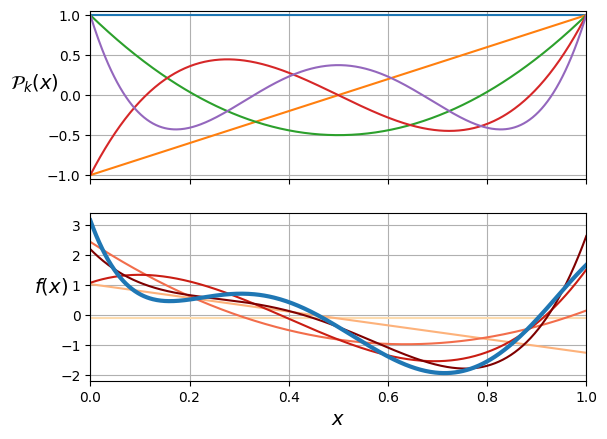

In [11]:
cmap = plt.get_cmap('OrRd')

x = torch.linspace(0, 1, 500)
k_max = 5
fig, axs = plt.subplots(2, 1, sharex=True)
for k in range(k_max):
    y = shifted_legendre_polynomial(k, x)
    axs[0].plot(x, y)
    axs[0].grid(True)
    axs[0].axis([0, 1, -1.05, 1.05])
    axs[0].set_ylabel(r"$\mathcal{P}_k(x)$   ", rotation=0)

torch.manual_seed(13)
weights = torch.randn(k_max + 3)
for k in range(1, k_max + 2):
    y = reconstructed_function(weights[:k], x)
    axs[1].plot(x, y, color=cmap(k / k_max))
    axs[1].set_xlabel("$x$")
    axs[1].set_ylabel(r"$f(x)$  ", rotation=0)
    axs[1].grid(True)
u = reconstructed_function(weights, x)
plt.plot(x, y, linewidth=3)

plt.show()

**Work in progress**